## Deep Learning Workshop 3 - Batch Normalization for CIFAR10 Dataset with Both CNNs & FCDNs
2019/09/11

[ Reference ]
+ Rui Shu, "**TENSORFLOW GUIDE: BATCH NORMALIZATION**", 2016/12/26. http://ruishu.io/2016/12/27/batchnorm/
    + Github code: https://github.com/RuiShu/micro-projects/blob/master/tf-batchnorm/batchnorm_guide.ipynb
+ Antoine Labatie, "**It’s Necessary to Combine Batch Norm and Skip Connections**", Towards Data Science, 2019/09/01. https://towardsdatascience.com/its-necessary-to-combine-batch-norm-and-skip-connections-e92210ca04da
+ Federico Peccia, "**Batch normalization: theory and how to use it with Tensorflow**", , Towards Data Science, 2018/09/16. https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad

-------------------------------
## [ CNNs ]: 
> 1. Please modify the TensorFlow code abovein **Case 1** for **CNNs**, and add "Convolution Layers" & "MaxPooling Layers", as following:
    + **Conv Layer 1**
    + **MaxPool Layer 1**
    + **Conv Layer 2**
    + **MaxPool Layer 2**
    + **Hidden Layer** 
    + **Hidden Layer** 
    + **Output Layer**
    
> 2. Using Batch Normalization by applying `tf.contrib.layers.batch_norm()` to `tf.contrib.layers.conv2d()`. 

> 3. And then, compare the results with those in **Case 1**.

[ REFERENCE ] :
+ dhwajraj, "How I can apply batch normalization?", 2016/12/07. https://github.com/dennybritz/cnn-text-classification-tf/issues/29
+ **`tf.contrib.layers.conv2d`**:https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d

> conv1 = `tf.contrib.layers.conv2d(...,
                                  normalizer_fn = tf.contrib.layers.batch_norm, 
                                  ...)`

> conv_out = `tf.nn.relu(conv1)`


+  **`tf.contrib.layers.batch_norm()`** :　https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

>+ It can be used as a **normalizer function** for `tf.contrib.layers.conv2d` and `tf.contrib.layers.fully_connected`. 
+ The normalization is over all but the last dimension if `data_format` is **NHWC** and all but the second dimension if `data_format` is **NCHW**. 
    + **NHWC** : (Samples, Height, Width, Channels)
    + **NCHW** : (Samples, Channels, Height, Width)
> + In case of a 2D tensor this corresponds to the batch dimension, while in case of a 4D tensor this corresponds to the batch and space dimensions.
------------------------

- [< Case Study > : Batch_Norm for Both CNNs & FCDNs](#BNforBoth)
- [< Exercise > : Batch_Norm for CIFAR-10 Dataset](#BNforCIFAR10)

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
# for the old-version usage of TensorFlow, such as tensorflow.examples.tutorials.mnist
old_v = tf.logging.get_verbosity()          
tf.logging.set_verbosity(tf.logging.ERROR) 

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


### Input CIFAR-10 dataset 

In [2]:
import numpy as np

class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
    
    def load(self):
        data = [unpickle(f) for f in self._source]
        # print(data)
        images = np.vstack([d[b"data"] for d in data])
        n = len(images)  # 32 x 32 x 3 channels
        self.images = images.reshape(n, 3, 32, 32).transpose(0, 2, 3, 1).astype(float) / 255
        self.labels = one_hot(np.hstack([d[b"labels"] for d in data]), 10)
        return self

    def next_batch(self, batch_size):
        x, y = self.images[self._i : self._i+batch_size], self.labels[self._i:self._i+batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y

In [3]:
import pickle
import os

##  Loading CIFAR-10 dataset from your Google Drive
##  DATA_PATH = "/content/drive/My Drive/Colab Notebooks/cifar-10-batches-py"

##  < for CIFAR-10 dataset on local host >
DATA_PATH = "./cifar-10-batches-py"

def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')   ##  encoding='bytes'
    return dict

def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [4]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i)
                                   for i in range(1, 6)]).load()
        self.test = CifarLoader(["test_batch"]).load()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test images: 10000


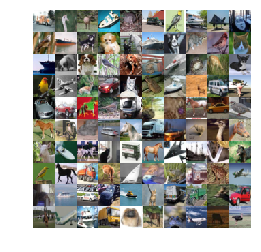

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)])
         for i in range(size)])
    plt.imshow(im)
    plt.show()
    
d = CifarDataManager()
print("Number of train images: {}".format(len(d.train.images)))
print("Number of train labels: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test images: {}".format(len(d.test.labels)))
images = d.train.images
display_cifar(images, 10)

--------------------------------------
<a id='BNforBoth'></a>
## < Case Study > : Batch_Norm for Both CNNs & FCDNs


> + **[NOTE]: the `phase` term. **
    + useed as a **placeholder for a boolean** which we will insert into ``feed_dict`. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 

In [13]:
def train_test():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    # --------------------------------------
    # Launch the computation graph...
    # --------------------------------------
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    batch_size = 100
    iterep = 500
    epochs = 30
    
    ##  mnist.test.validation.shape : (5000, 784)
    # X_val = mnist.validation.images.reshape(5, 1000, 28, 28, 1)
    ##  mnist.test.validation.shape : (5000, 10)
    # Y_val = mnist.validation.labels.reshape(5, 1000, 10)   

    for i in range(iterep * epochs):
        x_train, y_train = cifar.train.next_batch(batch_size)
        
        x_train = x_train.reshape(batch_size, 32, 32, 3)
        
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': x_train,
                                     'y:0': y_train,
                                     'phase:0': 1})

            # t_loss = np.mean([sess.run(loss,
            #                      feed_dict={'x:0': X_val[i], 
            #                                 'y:0': Y_val[i], 
            #                                 'phase:0': 0}) 
            #                      for i in range(5)])
            # t_accu = np.mean([sess.run(accuracy,
            #                      feed_dict={'x:0': X_val[i], 
            #                                 'y:0': Y_val[i], 
            #                                 'phase:0': 0}) 
            #                      for i in range(5)])
            # t = [t_loss, t_accu]

            # history += [[epoch] + tr + t]
            history += [[epoch] + tr]
            print(history[-1])
            
    print("\n Computing the test accuracy ... ", end = " ")
    
    ##  ------------------------------------------------------------------
    ##  Test datasets...
    ##
    ##  Split the test procedure into 10 blocks of 1,000 images each. 
    ##  Doing this is important mostly for much larger datasets.
    ##  ------------------------------------------------------------------
    X_test = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y_test = cifar.test.labels.reshape(10, 1000, 10)
    
    # test_loss = np.mean([sess.run(loss,
    #                               feed_dict={'x:0': X_test[i], 
    #                                          'y:0': Y_test[i], 
    #                                          'phase:0': 0}) 
    #                               for i in range(10)])
    test_accu = np.mean([sess.run(accuracy,
                                  feed_dict={'x:0': X_test[i], 
                                             'y:0': Y_test[i], 
                                             'phase:0': 0}) 
                                  for i in range(10)])
    # print("\n [ Accuracy ] : {:.4}%".format(test_acc * 100))
    print(" Done !!! ")
    
    return history, test_accu

## < Case 1 > : No batch normalization for Both CNNs & FCDNs

In [14]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [15]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

In [16]:
# Reset the default graph...
tf.reset_default_graph()

cifar = CifarDataManager()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 32, 32, 3), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# Conv layers with MaxPooling_2x2 layers
conv1 = conv_layer(x, shape=[3, 3, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[3, 3, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

# FCDNetwork with 2 hidden layers...
h1 = dense_relu(conv2_flat, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [17]:
history, test_accu = train_test()

[1.0, 1.9871325, 0.31]
[2.0, 1.7757283, 0.37]
[3.0, 1.5589212, 0.45]
[4.0, 1.4605948, 0.48]
[5.0, 1.3896282, 0.53]
[6.0, 1.3323169, 0.55]
[7.0, 1.2701482, 0.59]
[8.0, 1.219729, 0.57]
[9.0, 1.1715657, 0.59]
[10.0, 1.1329033, 0.6]
[11.0, 1.0922889, 0.63]
[12.0, 1.053486, 0.65]
[13.0, 1.0177888, 0.64]
[14.0, 0.9738764, 0.65]
[15.0, 0.9343226, 0.66]
[16.0, 0.8957131, 0.67]
[17.0, 0.8568331, 0.67]
[18.0, 0.8205267, 0.68]
[19.0, 0.7914129, 0.68]
[20.0, 0.75685847, 0.71]
[21.0, 0.7260182, 0.74]
[22.0, 0.6949018, 0.75]
[23.0, 0.6691542, 0.76]
[24.0, 0.6438576, 0.78]
[25.0, 0.61726993, 0.8]
[26.0, 0.59107965, 0.8]
[27.0, 0.56801736, 0.82]
[28.0, 0.54193383, 0.83]
[29.0, 0.5208432, 0.83]
[30.0, 0.49745125, 0.85]

 Computing the test accuracy ...   Done !!! 


In [18]:
# print(" [ Test  Accuracy ] : {}".format(test_accu) +
#       "\n [ Test Loss Score ] : {}".format(test_loss))

print(" [ Test  Accuracy ] : {}".format(test_accu))

 [ Test  Accuracy ] : 0.6857999563217163


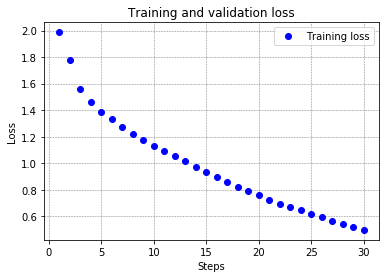

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
# plt.plot(steps, [history[i][3] for i in range(len(history))], 
#          'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

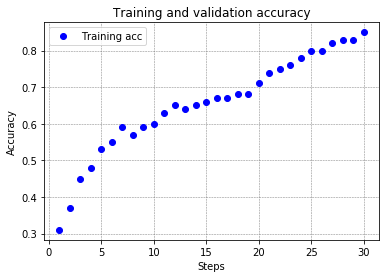

In [20]:
plt.clf()   # clear figure

plt.plot(steps, [history[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
# plt.plot(steps, [history[i][4] for i in range(len(history))], 
#         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## < Case 2 > : Standard batch normalization for Both CNNS & FCDNs
+ Batch normalization would be to simply use the `tf.contrib.layers.batch_norm layer`.
+ One thing that might stand out is the `phase` term. 
    + We are going to use as a **placeholder for a boolean** which we will insert into feed_dict. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 
    
    
+ Recall that batch normalization has distinct behaviors during training verus test time:
> + Training
    1. Normalize layer activations according to mini-batch statistics.
    2. During the training step, update population statistics approximation via moving average of mini-batch statistics.
 + Testing
    1. Normalize layer activations according to estimated population statistics.
    2. Do not update population statistics according to mini-batch statistcs from test data.

In [21]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        
        # Batch normalization would be to simply use the tf.contrib.layers.batch_norm layer.
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training = phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [22]:
def conv2d_bn(x, W, shape):
    # return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return tf.contrib.layers.convolution2d(x, shape[3],
                [shape[0],shape[1]], padding='SAME', 
                normalizer_fn=tf.contrib.layers.batch_norm)

def conv_layer_bn(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d_bn(input, W, shape) + b)

In [23]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 32, 32, 3), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# Conv layers with MaxPooling_2x2 layers
conv1 = conv_layer_bn(x, shape=[3, 3, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer_bn(conv1_pool, shape=[3, 3, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

# FCDNetwork with 2 hidden layers...
h1 = dense_batch_relu(conv2_flat, 100, 'layer1')
h2 = dense_batch_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [26]:
history_bn, test_accu_bn = train_test()

[1.0, 1.3415191, 0.53]
[2.0, 1.1499375, 0.61]
[3.0, 0.9883594, 0.68]
[4.0, 0.8442198, 0.75]
[5.0, 0.72864234, 0.79]
[6.0, 0.63281405, 0.79]
[7.0, 0.55081826, 0.83]
[8.0, 0.48592907, 0.85]
[9.0, 0.42203885, 0.88]
[10.0, 0.35583755, 0.93]
[11.0, 0.29573116, 0.96]
[12.0, 0.2467178, 0.98]
[13.0, 0.20111588, 0.99]
[14.0, 0.16573316, 1.0]
[15.0, 0.13392392, 1.0]
[16.0, 0.10883067, 1.0]
[17.0, 0.09153042, 1.0]
[18.0, 0.07564675, 1.0]
[19.0, 0.06328223, 1.0]
[20.0, 0.052422356, 1.0]
[21.0, 0.04415952, 1.0]
[22.0, 0.039649528, 1.0]
[23.0, 0.033584, 1.0]
[24.0, 0.029663779, 1.0]
[25.0, 0.02571002, 1.0]
[26.0, 0.022336647, 1.0]
[27.0, 0.020347865, 1.0]
[28.0, 0.018375106, 1.0]
[29.0, 0.016749362, 1.0]
[30.0, 0.015347241, 1.0]

 Computing the test accuracy ...   Done !!! 


In [27]:
print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn))
#      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu))
#      "\n [ Test Loss Score ] : {}".format(test_loss))

 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.6717000007629395

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.6857999563217163


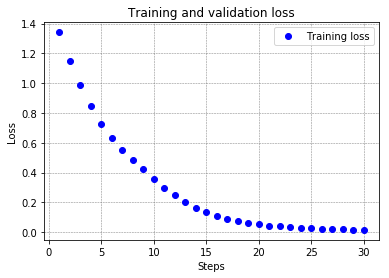

In [28]:
plt.clf()   # clear figure

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history_bn[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
# plt.plot(steps, [history_bn[i][3] for i in range(len(history))], 
#         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

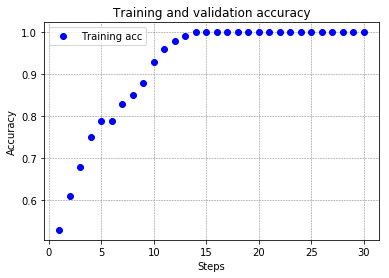

In [29]:
plt.clf()   # clear figure

plt.plot(steps, [history_bn[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
# plt.plot(steps, [history_bn[i][4] for i in range(len(history))], 
#         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## < Case 3 > : Post-activation batch normalization

In [30]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        
        ##  Post-activation batch normalization...
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [31]:
def conv_layer_relu_bn(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    relu_bn = tf.nn.relu(conv2d(input, W) + b)
    return tf.contrib.layers.convolution2d(relu_bn, shape[3],
                                        [shape[0],shape[1]], padding='SAME', 
                                        normalizer_fn=tf.contrib.layers.batch_norm)

In [32]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 32, 32, 3), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# Conv layers with MaxPooling_2x2 layers
conv1 = conv_layer_relu_bn(x, shape=[3, 3, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer_relu_bn(conv1_pool, shape=[3, 3, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

# FCDNetwork with 2 hidden layers...
h1 = dense_relu_batch(conv2_flat, 100, 'layer1')
h2 = dense_relu_batch(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [33]:
history_post_bn, test_accu_post_bn = train_test()

[1.0, 1.1356429, 0.64]
[2.0, 0.9131552, 0.68]
[3.0, 0.7645337, 0.76]
[4.0, 0.643135, 0.82]
[5.0, 0.54194385, 0.87]
[6.0, 0.4622781, 0.88]
[7.0, 0.39455277, 0.92]
[8.0, 0.3229128, 0.93]
[9.0, 0.2687238, 0.93]
[10.0, 0.22099923, 0.95]
[11.0, 0.17318499, 0.99]
[12.0, 0.13635376, 0.99]
[13.0, 0.10991499, 1.0]
[14.0, 0.08551747, 1.0]
[15.0, 0.06676392, 1.0]
[16.0, 0.05311506, 1.0]
[17.0, 0.043373223, 1.0]
[18.0, 0.03641837, 1.0]
[19.0, 0.03151938, 1.0]
[20.0, 0.026425123, 1.0]
[21.0, 0.022779942, 1.0]
[22.0, 0.02054623, 1.0]
[23.0, 0.01859722, 1.0]
[24.0, 0.016593786, 1.0]
[25.0, 0.01460364, 1.0]
[26.0, 0.013211875, 1.0]
[27.0, 0.011845721, 1.0]
[28.0, 0.011088236, 1.0]
[29.0, 0.010430737, 1.0]
[30.0, 0.009653831, 1.0]

 Computing the test accuracy ...   Done !!! 


In [34]:
print(" <<< Post-activation Batch Normalization >>> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_post_bn))
#      "\n [ Test Loss Score ] : {}".format(test_loss_post_bn))

print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn))
#      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu))
#      "\n [ Test Loss Score ] : {}".format(test_loss))

 <<< Post-activation Batch Normalization >>> :
 [ Test  Accuracy ] : 0.6920000314712524
 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.6717000007629395

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.6857999563217163


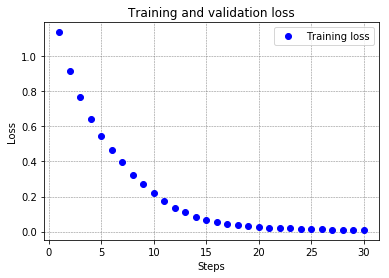

In [35]:
plt.clf()   # clear figure

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history_post_bn[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
# plt.plot(steps, [history_post_bn[i][3] for i in range(len(history))], 
#         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

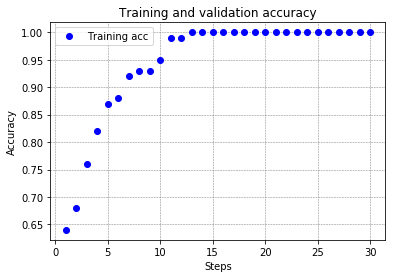

In [36]:
plt.clf()   # clear figure

plt.plot(steps, [history_post_bn[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
# plt.plot(steps, [history_post_bn[i][4] for i in range(len(history))], 
#         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## Evaluation

In [37]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [38]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

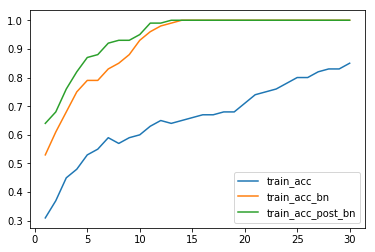

In [39]:
plt.plot(history[:, 0], history[:, -1], label='train_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='train_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='train_acc_post_bn')
plt.legend()
plt.show()

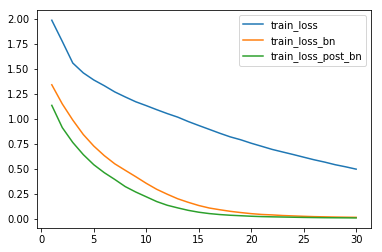

In [40]:
plt.clf()   # clear figure

plt.plot(history[:, 0], history[:, -2], label='train_loss')
plt.plot(history_bn[:, 0], history_bn[:, -2], label='train_loss_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -2], label='train_loss_post_bn')
plt.legend()
plt.show()

+ ### As you can see, batch normalization does not always help with training !!!

--------------------------------------
<a id='BNforCIFAR10'></a>
## < Exercise > : Batch_Norm for CIFAR-10 Datasets 

## [ Problem ]: 
> 1. Please modify the Case-Study TensorFlow code above for building a multiple-output classifier with the **CIFAR-10** dataset, which includes "Convolution Layers" & "MaxPooling Layers", as following:
    + **Conv Layer 1**
    + **Conv Layer 2**
    + **Conv Layer 3**
    + **MaxPool Layer**
    + **Conv Layer 1**
    + **Conv Layer 2**
    + **Conv Layer 3**
    + **MaxPool Layer**
    + **Conv Layer 1**
    + **Conv Layer 2**
    + **Conv Layer 3**
    + **MaxPool Layer**
    + **Hidden Layer** 
    + **Hidden Layer** 
    + **Output Layer**
    
> 2. Using Batch Normalization by applying `tf.contrib.layers.batch_norm()` to `tf.contrib.layers.conv2d()`. 

> 3. And then, compare the results with those in the reference below:
    + Tom Hope, Yehezkel S. Resheff, and Itay Lieder, "**`Learning TensorFlow : A Guide to Building Deep Learning Systems`**", Chapter 4, O'Reilly, 2017.
      [ Code ] : https://github.com/giser-yugang/Learning_TensorFlow.

[ REFERENCE ] :
+ dhwajraj, "How I can apply batch normalization?", 2016/12/07. https://github.com/dennybritz/cnn-text-classification-tf/issues/29
+ `tf.contrib.layers.conv2d`:https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d

> conv1 = `tf.contrib.layers.conv2d(...,
                                  normalizer_fn = tf.contrib.layers.batch_norm, 
                                  ...)`

> conv_out = `tf.nn.relu(conv1)`